In [1]:
import os
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import imageio

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Simulation Parameters
buy_rate = 25000.0 # Purchase rate per unit time for systematic buyers
sell_rate = 25000.0 # Sale rate per unit time for systematic sellers
eta0 = 0.0025 # CEX proportional cost
mu = 0.0  # Mean of CEX price shock

# Set of AMM Fee values from simulation
eta1_vals = np.array([i*0.00001 for i in range(0,1001)])

# Set of sigma values from simulation
sigma_vals = np.array([i*0.001 for i in range(1,101)])

In [3]:
# Read file
filename = f"../data/all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(buy_rate)}_sell_{round(sell_rate)}.pkl"

with open(filename, "rb") as f:
    sim_outputs = pickle.load(f)

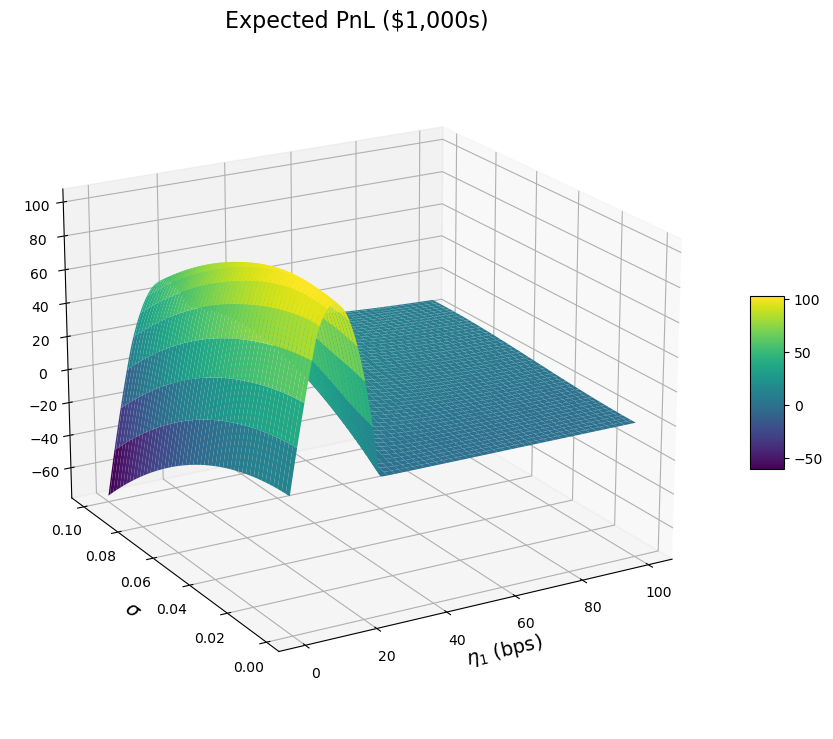

In [4]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
obj = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        obj[i, j] = (outputs[j,0]+outputs[j,1]+outputs[j,2]+outputs[j,3]-outputs[j,4])/1000 # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, obj, cmap='viridis')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.show()

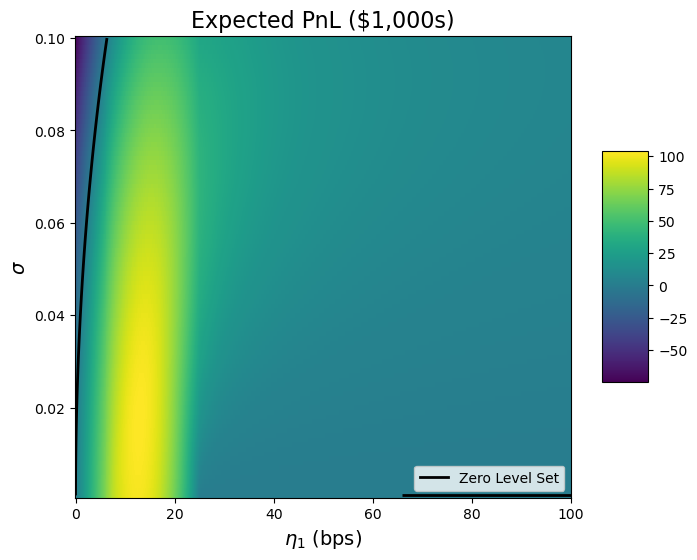

In [5]:
# Create a heatmap.
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolormesh(ETA * 10000, SIGMA, obj, cmap='viridis', shading='auto')

# Overlay a black contour line at the zero level of the objective function.
contour = ax.contour(ETA * 10000, SIGMA, obj, levels=[0], colors='black', linewidths=2)

# Create a proxy for the contour line to use in the legend.
zls_line = Line2D([0], [0], color='black', lw=2, label='Zero Level Set')

# Add the legend.
ax.legend(handles=[zls_line], loc='lower right')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add a colorbar.
cbar = fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('', fontsize=14)

plt.show()

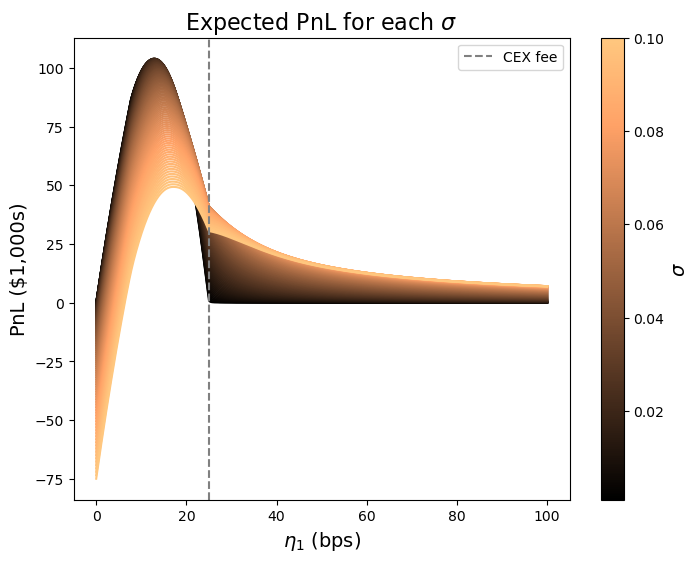

In [6]:
# Create a color gradient in the values of sigma.
norm_sigma = mpl.colors.Normalize(vmin=np.min(sigma_vals), vmax=np.max(sigma_vals))
cmap = plt.get_cmap("copper")

# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the objective (Expected PnL) as a function of eta1 for each sigma value.
for i, sigma in enumerate(sigma_vals):
    # Get a color corresponding to the current sigma and plot the objective.
    color = cmap(norm_sigma(sigma))
    ax.plot(eta1_vals * 10000, obj[i, :], color=color, label='')

# Add vertical line to indicate CEX fee level
plt.axvline(x=eta0 * 10000, color="grey", linestyle="--", label="CEX fee")

# Label the axes.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel('PnL ($1,000s)', fontsize=14)
ax.set_title(r'Expected PnL for each $\sigma$', fontsize=16)
ax.legend(loc='upper right')

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sigma)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\sigma$', fontsize=14)

plt.show()

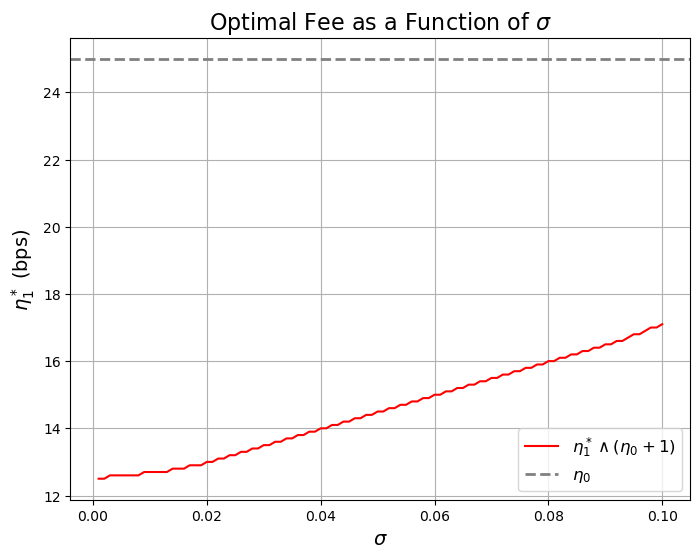

In [7]:
# Find the index of the maximum objective for each sigma (each row in obj)
optimal_indices = np.argmax(obj, axis=1)

# Map those indices to the corresponding eta1 values
optimal_eta1 = eta1_vals[optimal_indices]

# Cap the maximum eta1 to be eta0 + 0.0001 (for plotting)
optimal_eta1 = np.minimum(optimal_eta1, eta0 + 0.0001)

# Save optimal fees to a file
filename = "../data/optimal_fees_eta0_" + str(eta0) + "_mu_" + str(mu) \
            + "_buy_" + str(round(buy_rate)) + "_sell_" + str(round(sell_rate))+ ".pkl"

with open(filename, "wb") as f:
    pickle.dump(np.array([sigma_vals, optimal_eta1]), f)

# Plot optimal eta1 as a function of sigma
plt.figure(figsize=(8, 6))
plt.plot(sigma_vals, optimal_eta1 * 10000, linestyle='-', color='r', label=r'$\eta_1^* \wedge (\eta_0+1)$')
# Add horizontal line for eta0 (converted to bps)
plt.axhline(y=eta0 * 10000, color='grey', linestyle='--', linewidth=2, label=r'$\eta_0$')

plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel(r'$\eta_1^*$ (bps)', fontsize=14)
plt.title(r'Optimal Fee as a Function of $\sigma$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [8]:
# Simulation Parameters (not including eta0)
buy_rate = 2500.0  # Purchase rate per unit time for systematic buyers
sell_rate = 2500.0 # Sale rate per unit time for systematic sellers
mu = 0.0         # Mean of CEX price shock

# Values for sigma and eta1
eta1_vals = np.array([i * 0.00001 for i in range(0, 1001)])
sigma_vals = np.array([i * 0.001 for i in range(1, 101)])

# List of different eta0 values (that have simulation files)
eta0_values = [0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]

# First, determine global z-axis limits by scanning all files.
global_zmin, global_zmax = np.inf, -np.inf
for eta0 in eta0_values:
    filename = f"../data/all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(buy_rate)}_sell_{round(sell_rate)}.pkl"
    with open(filename, "rb") as f:
        sim_outputs = pickle.load(f)
    obj = np.empty((len(sigma_vals), len(eta1_vals)))
    for i, sigma in enumerate(sigma_vals):
        outputs = sim_outputs[sigma]
        for j in range(len(eta1_vals)):
            obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] +
                         outputs[j, 3] - outputs[j, 4]) / 1000  # Compute objective
    global_zmin = min(global_zmin, obj.min())
    global_zmax = max(global_zmax, obj.max())

# List to hold temporary filenames of each frame
frame_filenames = []

for eta0 in eta0_values:
    filename = f"../data/all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(buy_rate)}_sell_{round(sell_rate)}.pkl"
    with open(filename, "rb") as f:
        sim_outputs = pickle.load(f)
    
    obj = np.empty((len(sigma_vals), len(eta1_vals)))
    for i, sigma in enumerate(sigma_vals):
        outputs = sim_outputs[sigma]
        for j in range(len(eta1_vals)):
            obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] +
                         outputs[j, 3] - outputs[j, 4]) / 1000  # Compute objective

    ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)
    
    # Create figure and 3D axis.
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=-120)
    
    # Fixed axes: set limits for x (eta1 in bps), y (sigma) and z (objective).
    ax.set_xlim(eta1_vals.min() * 10000, eta1_vals.max() * 10000)
    ax.set_ylim(sigma_vals.min(), sigma_vals.max())
    ax.set_zlim(global_zmin, global_zmax)
    
    # Create surface plot (converting eta1 to bps).
    surface = ax.plot_surface(ETA * 10000, SIGMA, obj, cmap='viridis')
    
    ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
    ax.set_ylabel(r'$\sigma$', fontsize=14)
    ax.set_zlabel('Expected PnL ($1,000s)', fontsize=12)
    ax.set_title(f'Expected PnL for $\\eta_0$ = {eta0}', fontsize=16)
    
    fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
    
    frame_filename = f"frame_eta0_{eta0}.png"
    plt.savefig(frame_filename)
    frame_filenames.append(frame_filename)
    plt.close(fig)

# Create the GIF from the saved frames.
gif_filename = "simulation_animation.gif"
with imageio.get_writer(gif_filename, mode='I', duration=1) as writer:
    for fname in frame_filenames:
        image = imageio.v3.imread(fname)
        writer.append_data(image)

# Remove temporary image files.
for fname in frame_filenames:
    os.remove(fname)

print(f"GIF saved as {gif_filename}")


GIF saved as simulation_animation.gif
